<a href="https://colab.research.google.com/github/usuf9589/MT/blob/main/NLLB_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [2]:
from google.colab import files
import pandas as pd

# Upload files
#uploaded = files.upload()

# Read the files into lists
with open('/content/OpenSubtitles.en-fr.en', 'r', encoding='utf-8') as f:
    original_lines = f.readlines()

with open('/content/OpenSubtitles.en-fr.fr', 'r', encoding='utf-8') as f:
    translated_lines = f.readlines()

# Strip newline characters
original_lines = [line.strip() for line in original_lines]
translated_lines = [line.strip() for line in translated_lines]

# Create a DataFrame
data = pd.DataFrame({
    'Original': original_lines,
    'Translated': translated_lines,
    'Split': 'train'  # Adding the new column with constant value
})

# Update the Split column for the last 1000 rows
num_rows = len(data)
if num_rows > 1000:
    data.loc[num_rows-1000:, 'Split'] = 'dev'  # Last 1000 rows
    data.loc[num_rows-2000:num_rows-1000, 'Split'] = 'test'  # Previous 1000 rows

# Display the DataFrame
data.head()

# Save to CSV
data.to_csv('combined_data.tsv', sep='\t', index=False)




In [3]:
trans_df = pd.read_csv('/content/combined_data.tsv', sep="\t")
print(trans_df.shape)
print(trans_df.columns)

(216418, 3)
Index(['Original', 'Translated', 'Split'], dtype='object')


In [4]:
pd.options.display.max_colwidth = 100

In [5]:
trans_df.sample(10)

,Original,Translated,Split
94904,- What' s that?,"C'est quoi, ça?",train
103303,"Bring your arm down, and hit.","Mets ton bras en arrière, et frappe.",train
183614,Bob Hope?!,Bob Hope?,train
36956,Too risky.,Trop risqué!,train
148295,"- Hush, Scout.","Chut, Scout!",train
196745,"You know, it... it' s quite common to have a nickname there.","Tu sais, c'est... c'est assez commun d'avoir un surnom là- bas.",train
86551,- Voices?,- J'ai entendu des voix?,train
191872,So don' t talk to me about confusion.,Me parle pas d'embrouillement.,train
183677,The other 90 percent is below the water where you can' t see it.,"90% sont sous l'eau, invisibles.",train
145447,I don' t think so.,Vous avez autre chose à me dire?,train


In [6]:
trans_df.isnull().sum()

,0
Original,0
Translated,0
Split,0


In [7]:
trans_df.Split.value_counts()

,count
Split,
train,214418
test,1001
dev,999


In [8]:
df_train = trans_df[trans_df.Split=='train'].copy()
df_dev = trans_df[trans_df.Split=='dev'].copy()
df_test = trans_df[trans_df.Split=='test'].copy()

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=1)

smpl['fr_toks'] = smpl.Translated.apply(tokenizer.tokenize)
smpl['en_toks'] = smpl.Original.apply(tokenizer.tokenize)

smpl['fr_words'] = smpl.Translated.apply(word_tokenize)
smpl['en_words'] = smpl.Original.apply(word_tokenize)

In [13]:
smpl.sample(5)[['Original', 'en_words', 'en_toks', 'Translated', 'fr_words', 'fr_toks']]

,Original,en_words,en_toks,Translated,fr_words,fr_toks
207615,"No, County will cover that.","[No, ,, County, will, cover, that, .]","[▁No, ,, ▁County, ▁will, ▁cover, ▁that, .]","Non, le County va s'en charger.","[Non, ,, le, County, va, s, ', en, charger, .]","[▁Non, ,, ▁le, ▁County, ▁va, ▁s, ', en, ▁char, ger, .]"
133875,Yeah.,"[Yeah, .]","[▁Yeah, .]",Ok.,"[Ok, .]","[▁Ok, .]"
4283,I need a few moments of the commander' s time.,"[I, need, a, few, moments, of, the, commander, ', s, time, .]","[▁I, ▁need, ▁a, ▁few, ▁moments, ▁of, ▁the, ▁command, er, ', ▁s, ▁time, .]",Je dois parler un moment au commandant.,"[Je, dois, parler, un, moment, au, commandant, .]","[▁Je, ▁dois, ▁parler, ▁un, ▁moment, ▁au, ▁command, ant, .]"
138436,Let' s just cut to the chase.,"[Let, ', s, just, cut, to, the, chase, .]","[▁Let, ', ▁s, ▁just, ▁cut, ▁to, ▁the, ▁ch, ase, .]",Parlons franchement.,"[Parlons, franchement, .]","[▁Parl, ons, ▁fran, ch, ement, .]"
117289,"{y: i} [Answering Machine Continues, {y: i} Indistinct]","[{, y, :, i, }, [, Answering, Machine, Continues, ,, {, y, :, i, }, Indistinct, ]]","[▁{, y, :, ▁i, }, ▁[, A, ns, wer, ing, ▁Machine, ▁Continu, es, ,, ▁{, y, :, ▁i, }, ▁Ind, istin, ...","Rafraîchis- moi la mémoire, Ron.","[Rafraîchis, -, moi, la, mémoire, ,, Ron, .]","[▁Raf, ra, î, chis, -, ▁moi, ▁la, ▁mé, mo, ire, ,, ▁Ron, .]"


In [14]:
stats = smpl[['fr_toks', 'en_toks', 'fr_words', 'en_words']].applymap(len).describe()
stats

<ipython-input-14-6bf3f13fd42d>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[['fr_toks', 'en_toks', 'fr_words', 'en_words']].applymap(len).describe()


,fr_toks,en_toks,fr_words,en_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.603200,9.020200,8.301500,8.496100
std,6.809595,6.075877,5.959106,5.989088
min,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000
50%,8.000000,8.000000,7.000000,7.000000
75%,12.000000,11.000000,10.000000,10.000000
max,193.000000,116.000000,171.000000,115.000000


In [15]:
print(stats.fr_toks['mean'] / stats.fr_words['mean'])
print(stats.en_toks['mean'] / stats.en_words['mean'])

1.1568029874119132
1.0616871270347572


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


In [17]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [18]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


256204
['zul_Latn', '<mask>']


In [19]:
def fix_tokenizer(tokenizer, new_lang='en_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [20]:
fix_tokenizer(tokenizer)

In [21]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'en_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'en_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'en_Cyrl', '<mask>']
[256202, 256203, 256204]


In [22]:
added_token_id = tokenizer.convert_tokens_to_ids('en_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [23]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Embedding(256205, 1024)

In [24]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

In [25]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [26]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [29]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 50
training_steps = 100

In [30]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [32]:
def preproc(text):
    """Preprocesses the input text."""
    # Example preprocessing: lowercasing
    return text.lower()

In [33]:
LANGS = [('Translated', 'en_Cyrl'), ('Original', 'en_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, lang1), (l2, lang2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, lang1, lang2

print(get_batch_pairs(1))
# (['чеди'], ['семь'], 'tyv_Cyrl', 'rus_Cyrl')

(['tu dramatises.'], ["you' re overreacting."], 'en_Cyrl', 'en_Cyrl')


In [34]:
MODEL_SAVE_PATH = '/gd/MyDrive/models/nllb-en-fr-v1'

In [35]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/100 [00:00<?, ?it/s]

0 4.31162691116333


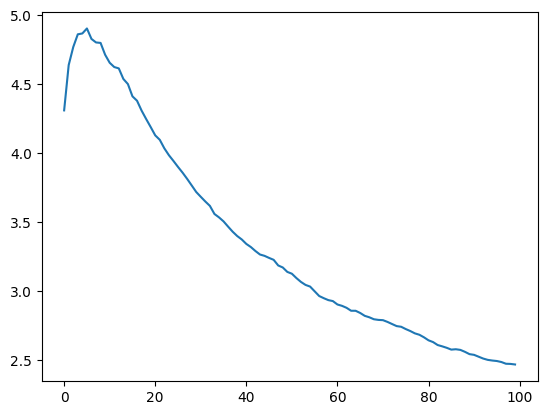

In [36]:
pd.Series(losses).ewm(100).mean().plot();

In [37]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [38]:
print(bleu_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(yy, [xx]))

BLEU = 4.72 23.8/4.7/2.9/1.8 (BP = 0.961 ratio = 0.962 hyp_len = 101 ref_len = 105)
chrF2++ = 16.74
chrF2++ = 17.45


In [39]:
def translate(text, src_lang='en_Cyrl', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [40]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

["ce n'est pas moi."]
['this is not me!']
["c'est pas moi."]
